In [1]:
## last edited: 6/6/22
## Status: able to import in situ text files through pandas and convert them to xarray datasets. Working on cleaning up
##         data and making plots.

In [1]:
# import packages and plotting scripts

import numpy as np
import os
import matplotlib.pyplot as plt
import xarray as xr
from datetime import datetime
import warnings
import pandas as pd
import cartopy.crs as ccrs
import shapely.geometry as sgeom
import matplotlib.patches as mpatches

os.chdir(  "/Users/etmu9498/research/code/scripts")
import make_plots
import goes_gifs

In [2]:
# view datasets

# paths to data
flight_path = "/Users/etmu9498/research/data/in-situ"
crl_path = "/Users/etmu9498/research/data/CRL_data/2021"
tdr_path = "/Users/etmu9498/research/data/tdr/sam/nc-files"

# load data to these variables
tdr_list = make_plots.load_tdr(tdr_path)
crl_list = make_plots.load_crl(crl_path)
flight_list = make_plots.load_flight_level( flight_path )

tdr data files:
0) 210926H1_2237_vert_inbound.nc
1) 210926H1_2237_vert_outbound.nc
2) 210926H1_2350_vert_inbound.nc
3) 210926H1_2350_vert_outbound.nc
4) 210926H1_2457_vert_inbound.nc
5) 210926H1_2457_vert_outbound.nc
6) 210927H1_2205_vert_inbound.nc
7) 210927H1_2205_vert_outbound.nc
8) 210927H1_2320_vert_inbound.nc
9) 210927H1_2320_vert_outbound.nc
10) 210927H1_2433_vert_inbound.nc
11) 210927H1_2433_vert_outbound.nc
12) 210929H2_2137_vert_inbound.nc
13) 210929H2_2137_vert_outbound.nc
14) 210929H2_2249_vert_inbound.nc
15) 210929H2_2249_vert_outbound.nc
16) 210929H2_2402_vert_inbound.nc
17) 210929H2_2402_vert_outbound.nc
in situ data files:
0) 20210527H1_iwg1.txt
1) 20210713H1_iwg1.txt
2) 20210716H1_iwg1.txt
3) 20210811H1_iwg1.txt
4) 20210812H1_iwg1.txt
5) 20210812H2_iwg1.txt
6) 20210813H1_iwg1.txt
7) 20210816H1_iwg1.txt
8) 20210817H1_iwg1.txt
9) 20210818H1_iwg1.txt
10) 20210818I1_iwg1.txt
11) 20210818N1_iwg1.txt
12) 20210819H1_iwg1.txt
13) 20210819N1_iwg1.txt
14) 20210820H1_iwg1.txt
15)

In [18]:
# load crl and tdr data
os.chdir( crl_path)
crl_name = crl_list[16]
crl_data = xr.open_dataset( crl_name)
os.chdir( tdr_path)
inbound_data = tdr_list[0]
outbound_data = tdr_list[1]


# load in situ data
os.chdir( flight_path)
in_situ_data = pd.read_csv( flight_list[31], header=None)

# make in situ data more manageable to work with using pandas, then convert to xarray
in_situ_data.columns = in_situ_data.iloc[3]
# in_situ_data.drop(in_situ_data.index[3])
# print( in_situ_data.shape)


# removing 1203 rows that just repeat the header keys, and 6 rows with empty lat lon
in_situ_data = in_situ_data[ in_situ_data['TIME'] != 'TIME']
in_situ_data = in_situ_data[ ~ pd.isna( in_situ_data['LATref']) ]
# removing 4 columns that are labeled as 'none'
in_situ_data.drop( 'none', inplace=True, axis=1)

# trim out every 10th element for a new, smaller dataset. Easier / faster to work with?
in_situ_data_trim = in_situ_data.iloc[ ::50, :]
# reset indices so they're nice and pretty!
in_situ_data_trim = in_situ_data_trim.reset_index( drop=True)
# in_situ_data_trim


# convert from pandas to xarray
xr_in_situ =  pd.DataFrame.to_xarray( in_situ_data_trim) # xr.DataSet.from_dataframe( in_situ_data_trim)
# remove 'index' from the coordinates tab... not sure about this?
xr_in_situ = xr_in_situ.drop_vars( 'index') # this doesn't work... xr_in_situ.reset_coords( 'index', drop=True)

xr_in_situ

<xarray.Dataset>
Dimensions:            (index: 723)
Dimensions without coordinates: index
Data variables: (12/131)
    IWG1_NAMES         (index) object 'IWG1' 'IWG1' 'IWG1' ... 'IWG1' 'IWG1'
    TIME               (index) object '20210926T180603' ... '20210927T041014'
    LATref             (index) object '17.7002' '17.7002' ... '17.6273'
    LONref             (index) object '-64.7943' '-64.7943' ... '-64.7832'
    ALTref             (index) object '15.2' '15.5' '15.7' ... '668.4' '613.0'
    GPS_GeoidHt.3      (index) object nan nan nan nan nan ... nan nan nan nan
    ...                 ...
    TRadD.1            (index) object '37.61' '37.65' ... '28.59' '27.99'
    TRadS.1            (index) object '28.45' '28.25' ... '15.04' '15.02'
    TRKdesired.d       (index) object '252.47' '260.44' ... '162.82' '167.69'
    TTM.1              (index) object '33.80' '33.98' ... '28.39' '27.39'
    TTM.2              (index) object '33.79' '34.02' ... '28.31' '27.24'
    TVIRT.d            (index) object '309.94' '310.09' ... '305.97' '301.98'

In [62]:
'''
# testing conversions necessary for datetime objects
print( xr_in_situ.LATref) 
print( xr_in_situ.TIME.values)
print( type( str( xr_in_situ.TIME[0].values)))
print( len( xr_in_situ.TIME.values))

date_time = np.zeros( len( xr_in_situ.TIME.values))
date_time = np.astype( 'datetime.datetime')
'''

# make a list of datetime objects from the 'TIME' column in the xarray dataset
date_time = []
for i in range( len( xr_in_situ.TIME.values)):
    
    # read each time value from xarray as a string
    timei = str( xr_in_situ.TIME[i].values)
    # convert to datetime object and save into python list
    date_time.append( datetime.strptime( timei, '%Y%m%dT%H%M%S') )

    # testing
    # print( str( xr_in_situ.TIME[i].values))
    # print( type( str( xr_in_situ.TIME[i].values)))

# convert from python list to numpy array
date_time = np.asarray( date_time)
print( len( date_time))
print( len( xr_in_situ.LATref ))

# xr_in_situ['time-new']=([], date_time)

723
723


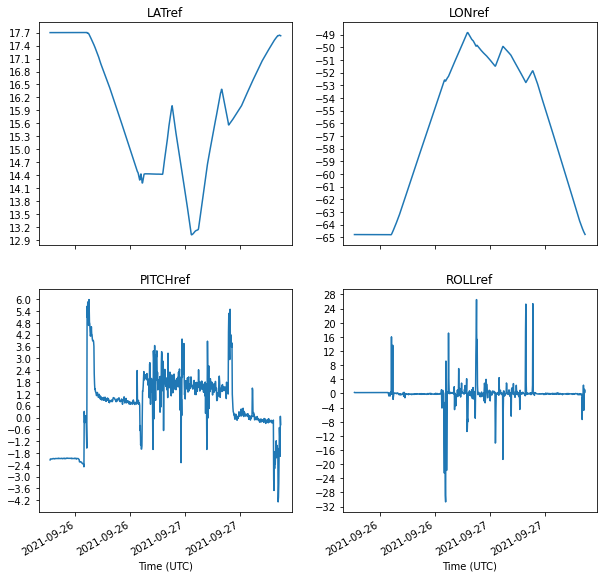

In [89]:
# make line plots showing how important in situ properties vary over time
'''
print( np.max( xr_in_situ.LATref.values))
print( np.min( xr_in_situ.LATref.values))
print( np.max( xr_in_situ.LONref.values))
print( np.min( xr_in_situ.LONref.values))
print( type( xr_in_situ.LONref.values[0]))
print( np.size( xr_in_situ.LONref.values))   
'''

fig=plt.figure(1, figsize=(10, 10))

ax1 = plt.subplot(221)
lat = xr_in_situ.LATref.values
lat = [ float( line) for line in lat]

plt.plot( date_time, lat )
ax1.set_xlabel( "Time (UTC)")
ax1.set_title( 'LATref')
ax1.xaxis.set_major_locator( plt.MaxNLocator( 5))
ax1.yaxis.set_major_locator( plt.MaxNLocator( 20))

ax2 = plt.subplot(222)
lon = xr_in_situ.LONref.values
lon = [ float( line) for line in lon]

ax2.set_xlabel( "Time (UTC)")
plt.plot( date_time, lon )
ax2.set_title( 'LONref')
ax2.xaxis.set_major_locator( plt.MaxNLocator( 5))
ax2.yaxis.set_major_locator( plt.MaxNLocator( 20))

ax3 = plt.subplot( 223)
pitch = xr_in_situ.PITCHref.values
pitch = [ float( line) for line in pitch]

ax3.set_xlabel( "Time (UTC)")
plt.plot( date_time, pitch )
ax3.set_title( 'PITCHref')
ax3.xaxis.set_major_locator( plt.MaxNLocator( 5))
ax3.yaxis.set_major_locator( plt.MaxNLocator( 20))

ax4 = plt.subplot( 224)
roll = xr_in_situ.ROLLref.values
roll = [ float( line) for line in roll]

ax4.set_xlabel( "Time (UTC)")
plt.plot( date_time, roll )
ax4.set_title( 'ROLLref')
ax4.xaxis.set_major_locator( plt.MaxNLocator( 5))
ax4.yaxis.set_major_locator( plt.MaxNLocator( 20))

plt.gcf().autofmt_xdate()


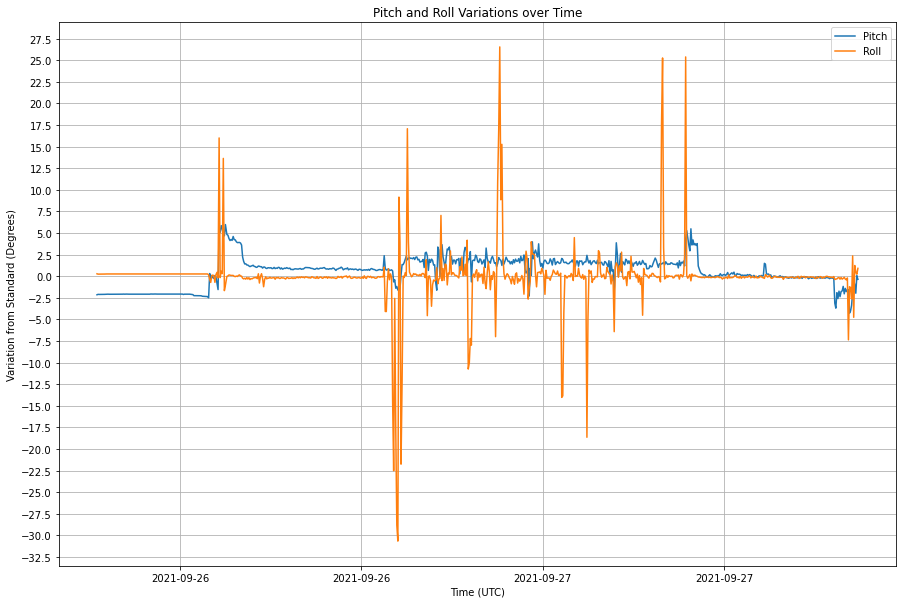

In [86]:
# plotting pitch and roll changes on top of each other to figure out turning points

fig=plt.figure(1, figsize=(15, 10))

ax = plt.subplot( 111)
pitch = xr_in_situ.PITCHref.values
pitch = [ float( line) for line in pitch]
plt.plot( date_time, pitch, label="Pitch" )

roll = xr_in_situ.ROLLref.values
roll = [ float( line) for line in roll]
plt.plot( date_time, roll, label="Roll" )

ax.set_xlabel( "Time (UTC)")
ax.set_ylabel( "Variation from Standard (Degrees)")
ax.set_title( 'Pitch and Roll Variations over Time')
ax.xaxis.set_major_locator( plt.MaxNLocator( 5))
ax.yaxis.set_major_locator( plt.MaxNLocator( 30))

plt.grid( 'on')
plt.legend()
# plt.gcf().autofmt_xdate()


2021-09-26T22:18:25.2Z
<xarray.DataArray 'Lon' ()>
array(-48.83850098)
<xarray.DataArray 'Lon' ()>
array(-52.79249954)


AttributeError: module 'pandas' has no attribute 'max'

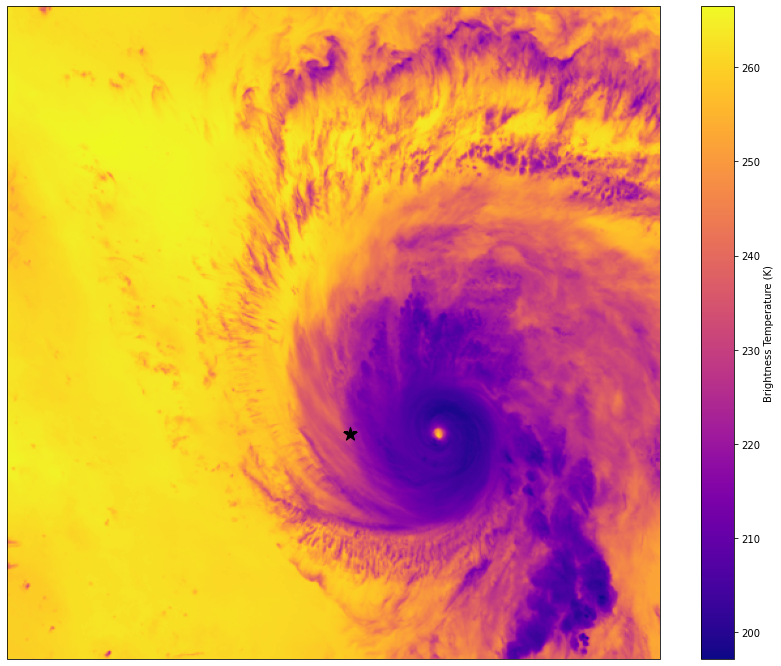

In [12]:
# load goes data
goes_data_path = "/Users/etmu9498/research/data/goes-satellite/0926"
# goes_data_path = "/Users/etmu9498/research/data/goes-satellite/0829"
goes_names = goes_gifs.load_goes( goes_data_path)

channel_name = "CMI_C10"
channel_full_name = "GOES-16 Lower Water Vapor Channel"
os.chdir( goes_data_path)
first_dataset = xr.open_dataset( goes_names[ 0])
plot_color = 'plasma'
flight_line_color = 'k'


C = xr.open_dataset( goes_names[ 0])
print( C.time_coverage_start)
scan_start = datetime.strptime(C.time_coverage_start, '%Y-%m-%dT%H:%M:%S.%fZ')
scan_end = datetime.strptime(C.time_coverage_end, '%Y-%m-%dT%H:%M:%S.%fZ')
file_created = datetime.strptime(C.date_created, '%Y-%m-%dT%H:%M:%S.%fZ')
midpoint = str(C['t'].data)[:-8]
scan_mid = datetime.strptime(midpoint, '%Y-%m-%dT%H:%M:%S.%f')

# access wv data!
wv_upper = C[ channel_name].data

# make figure
fig = plt.figure(figsize=(15, 12))
# these steps use goes ch 2 as a proxy to load things like lat and lon positions
dat = C.metpy.parse_cf('CMI_C02')
x = dat.x
y = dat.y
geos = dat.metpy.cartopy_crs
ax = fig.add_subplot(1, 1, 1, projection=geos)


# plot goes data
img = ax.imshow( wv_upper, origin='upper',
          cmap= plot_color, # plt.cm.get_cmap( 'cividis').reversed(), # "CMRmap",
          extent=(x.min(), x.max(), y.min(), y.max()),
          transform=geos )
fig.colorbar(mappable=img, label="Brightness Temperature (K)")

# dots
mid_int = ( int( midpoint[11:13]) + int( midpoint[14:16]) / 60 + int(midpoint[17:19] ) / 3600 )
if mid_int < 10.0:
    mid_int = mid_int + 24.0
# look at only the decimal places for time ( minutes + seconds)
for i in range( len( crl_data.time)):
    if ( crl_data.time[i] % 1 <= mid_int % 1 + .01) and ( crl_data.time[i] % 1 >= mid_int % 1 -.01) and (np.rint( crl_data.time[i] ) == np.rint( mid_int)):
        # make star
        long = crl_data.Lon[i].values
        latit = crl_data.Lat[i].values
        ax.scatter( long, latit, s=200, c= flight_line_color, marker='*', transform=ccrs.PlateCarree() ) # marker = 's'
        break

lon = crl_data.Lon
print( np.max( lon))
print( np.min( lon))
print( pd.max( in_situ_data['LONref']))
print( pd.min( in_situ_data['LONref']))

lat = crl_data.Lat
track = sgeom.LineString(zip(lon, lat))
center_lon = C.geospatial_lat_lon_extent.geospatial_lon_center

# crs_geo = ccrs.Geostationary(central_longitude=center_lon, globe=ccrs.Globe(semimajor_axis=6378137.0,semiminor_axis=6356752.3))
crs_geo = ccrs.PlateCarree() 
# ccrs.Miller())
# ccrs.Mercator())
# ax.add_geometries([track], crs=crs_geo,facecolor='none', edgecolor= 'g', linewidth=1)
# ax.plot( lon, lat,c = flight_line_color, transform= crs_geo )
# ax.plot( in_situ_data['LONref'], in_situ_data['LATref'], c = flight_line_color, transform=crs_geo)

# legend and title
shape = mpatches.Rectangle((0, 0), 1, 1, facecolor=flight_line_color)
ax.legend([ shape], ['CRL Flight Path'])
plt.title( channel_full_name, fontweight='bold', fontsize=15, loc='left')
plt.title('TC Sam, {}'.format(scan_start.strftime('%H:%M UTC %d %B %Y')),
          loc='right')
ax.gridlines(draw_labels=True)